Using device: /GPU:0


W0000 00:00:1755103516.490075   21324 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall_1/StatefulPartitionedCall_50/StatefulPartitionedCall_1/StatefulPartitionedCall/assert_greater_2/Assert/AssertGuard/branch_executed/_95316


Epoch     0, Loss: 413.97816 (Uni: 199.34317, Bi: 214.63486, Reg: 1.26520e-04), LR: 0.005000
Epoch   100, Loss: 149.54729 (Uni: 58.01699, Bi: 91.53012, Reg: 1.78209e-04), LR: 0.005000
Epoch   200, Loss: 0.61477 (Uni: 0.12659, Bi: 0.48797, Reg: 2.11711e-04), LR: 0.005000
Epoch   300, Loss: 0.16744 (Uni: 0.06766, Bi: 0.09955, Reg: 2.23547e-04), LR: 0.005000
Epoch   400, Loss: 0.10891 (Uni: 0.04333, Bi: 0.06535, Reg: 2.33171e-04), LR: 0.005000
Epoch   500, Loss: 0.06185 (Uni: 0.01560, Bi: 0.04601, Reg: 2.45691e-04), LR: 0.005000
Epoch   600, Loss: 0.05051 (Uni: 0.01313, Bi: 0.03715, Reg: 2.39378e-04), LR: 0.005000
Epoch   700, Loss: 0.04059 (Uni: 0.00961, Bi: 0.03075, Reg: 2.34214e-04), LR: 0.005000
Epoch   800, Loss: 0.03381 (Uni: 0.00810, Bi: 0.02547, Reg: 2.35421e-04), LR: 0.005000
Epoch   900, Loss: 0.03014 (Uni: 0.00904, Bi: 0.02086, Reg: 2.36726e-04), LR: 0.005000
Epoch  1000, Loss: 0.02718 (Uni: 0.00981, Bi: 0.01713, Reg: 2.37973e-04), LR: 0.005000
Epoch  1100, Loss: 0.02478 (Uni: 

W0000 00:00:1755103741.952879   21324 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall_1/StatefulPartitionedCall/assert_greater_1/Assert/AssertGuard/branch_executed/_997
W0000 00:00:1755103809.550843   21324 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall_1/StatefulPartitionedCall_1/StatefulPartitionedCall/assert_greater_2/Assert/AssertGuard/branch_executed/_68153


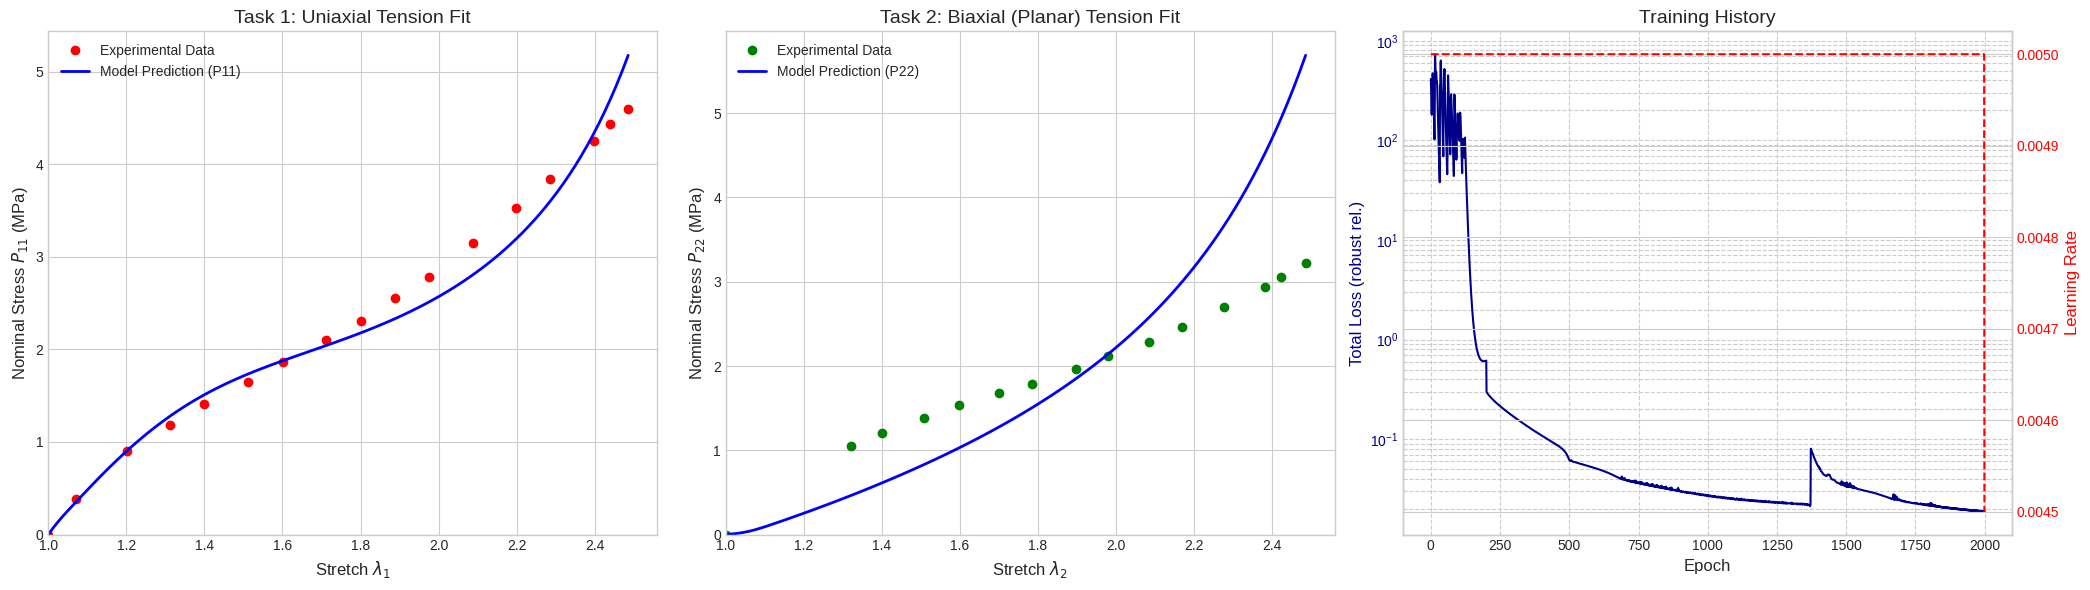

W0000 00:00:1755103858.005232   21324 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall_1/StatefulPartitionedCall/assert_greater_1/Assert/AssertGuard/branch_executed/_997
W0000 00:00:1755103926.994020   21324 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall_1/StatefulPartitionedCall_1/StatefulPartitionedCall/assert_greater_2/Assert/AssertGuard/branch_executed/_68153



Final check (clamped to zero within tolerance):
P11 at lambda1=1: 0.000000e+00
P22 at lambda2=1: 0.000000e+00


In [2]:
# --- Dependencies ---
# If running in Colab or a fresh env, keep these.
# !pip install tensorflow -q
# !pip install -U "seaborn" --quiet
# HARD-CODE: These pip lines assume an interactive environment (e.g., Colab). Keep commented in scripts.
# SUGGESTION: Move environment setup to a separate requirements file and preinstall via pip/conda.

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# --- Reproducibility ---
# HARD-CODE: Fixed random seed (42).
# SUGGESTION: Make seed configurable via an argument or env var, e.g., int(os.getenv("SEED", "42"))
tf.keras.utils.set_random_seed(42)

# --- Setup, Model Definition, Helper/Physics Functions ---
# CHANGE: Using float64 as you had.
# REASON: High precision is important for stiff gradients in hyperelasticity.
tf.keras.backend.set_floatx('float64')

# HARD-CODE: Device selection prints first GPU if present; otherwise CPU.
# SUGGESTION: Allow overriding via an env var, e.g., DEVICE = os.getenv("TF_DEVICE", auto_selected_value)
DEVICE = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {DEVICE}")

# Global numeric guards
# HARD-CODE: Argument clip window for exp/sinh/cosh inputs.
# SUGGESTION: Expose via a config dict (e.g., CONFIG["arg_clip"] = (-10.0, 10.0))
tf.keras.backend.clear_session()
tf.config.set_visible_devices([], 'GPU')  # Disable GPU if not needed
with tf.device('/CPU:0'):
    ARG_CLIP_MIN = tf.constant(-10.0, dtype=tf.float64)
    ARG_CLIP_MAX = tf.constant(10.0, dtype=tf.float64)

# HARD-CODE: Epsilon/tolerances.
# SUGGESTION: Centralize in a config and log them; tune per dataset if needed.
EPS = tf.constant(1e-12, dtype=tf.float64)          # general epsilon
REL_DEN_EPS = tf.constant(1e-8, dtype=tf.float64)   # epsilon for relative error denom
NEAR_ZERO_TOL = tf.constant(1e-10, dtype=tf.float64)  # CHANGE: Used to clamp ±1e-10 to 0
# REASON: Eliminates tiny residual negatives like -1.8e-08 due to fp rounding.

# Caps for learned exponents to prevent overflow in pow(I, k) and pow(arg, i)
# HARD-CODE: Bounds for k and i.
# SUGGESTION: Promote to config so you can sweep ranges without code edits.
K_MIN = tf.constant(1.0, dtype=tf.float64)
K_MAX = tf.constant(6.0, dtype=tf.float64)     # keep moderate growth on invariants
I_MIN = tf.constant(1.0, dtype=tf.float64)
I_MAX = tf.constant(4.0, dtype=tf.float64)     # cap i-exponents

# Optional: toggle invariant normalization (kept OFF by default to preserve your physics)
# HARD-CODE: This toggle is defined in code.
# SUGGESTION: Pass as a flag/CLI arg; optionally choose per-dataset.
NORMALIZE_INVARIANTS = False

@tf.function
def smooth_relu(x, beta=20.0):
    """A smooth, differentiable approximation of ReLU to avoid kinks near 0."""
    # HARD-CODE: beta=20.0 sharpness.
    # SUGGESTION: Make beta a module-level or model-level parameter to tune smoothness.
    return tf.nn.softplus(beta * x) / beta

class StrainEnergyANN_Layered_TF(tf.keras.Model):
    def __init__(self):
        super().__init__(name="StrainEnergyModel")
        # All model parameters are defined here. b1 is computed, not trainable.
        
        # HARD-CODE: Initializers (stddev=0.01). These are reasonable but fixed.
        # SUGGESTION: Allow stddev to be passed in or scaled by data magnitude.

        # ---- k's ----
        self.raw_log_k1 = self.add_weight(
            name="raw_log_k1", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k2 = self.add_weight(
            name="raw_log_k2", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k3 = self.add_weight(
            name="raw_log_k3", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k4 = self.add_weight(
            name="raw_log_k4", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k5 = self.add_weight(
            name="raw_log_k5", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k6 = self.add_weight(
            name="raw_log_k6", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k7 = self.add_weight(
            name="raw_log_k7", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k8 = self.add_weight(
            name="raw_log_k8", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k9 = self.add_weight(
            name="raw_log_k9", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k10 = self.add_weight(
            name="raw_log_k10", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k11 = self.add_weight(
            name="raw_log_k11", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k12 = self.add_weight(
            name="raw_log_k12", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k13 = self.add_weight(
            name="raw_log_k13", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k14 = self.add_weight(
            name="raw_log_k14", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k15 = self.add_weight(
            name="raw_log_k15", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_k16 = self.add_weight(
            name="raw_log_k16", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )

        # ---- i's ----
        self.raw_log_i1 = self.add_weight(
            name="raw_log_i1", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_i2 = self.add_weight(
            name="raw_log_i2", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_i3 = self.add_weight(
            name="raw_log_i3", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_i4 = self.add_weight(
            name="raw_log_i4", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_i5 = self.add_weight(
            name="raw_log_i5", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_i6 = self.add_weight(
            name="raw_log_i6", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_i7 = self.add_weight(
            name="raw_log_i7", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )
        self.raw_log_i8 = self.add_weight(
            name="raw_log_i8", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )

        # ---- a's ----
        self.raw_log_a1 = self.add_weight(
            name="raw_log_a1", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )
        self.raw_log_a2 = self.add_weight(
            name="raw_log_a2", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )
        self.raw_log_a3 = self.add_weight(
            name="raw_log_a3", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )
        self.raw_log_a4 = self.add_weight(
            name="raw_log_a4", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )
        self.raw_log_a5 = self.add_weight(
            name="raw_log_a5", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )
        self.raw_log_a6 = self.add_weight(
            name="raw_log_a6", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )
        self.raw_log_a7 = self.add_weight(
            name="raw_log_a7", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )
        self.raw_log_a8 = self.add_weight(
            name="raw_log_a8", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )

        # ---- b's ----
        self.raw_log_b2 = self.add_weight(
            name="raw_log_b2", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.01)),
            trainable=True
        )
        self.raw_log_b3 = self.add_weight(
            name="raw_log_b3", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )
        self.raw_log_b4 = self.add_weight(
            name="raw_log_b4", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )
        self.raw_log_b5 = self.add_weight(
            name="raw_log_b5", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )
        self.raw_log_b6 = self.add_weight(
            name="raw_log_b6", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )
        self.raw_log_b7 = self.add_weight(
            name="raw_log_b7", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )
        self.raw_log_b8 = self.add_weight(
            name="raw_log_b8", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.1)),
            trainable=True
        )

        # ---- primes ----
        self.raw_log_a3_prime = self.add_weight(
            name="raw_log_a3_prime", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.2)),
            trainable=True
        )
        self.raw_log_a4_prime = self.add_weight(
            name="raw_log_a4_prime", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.2)),
            trainable=True
        )
        self.raw_log_a5_prime = self.add_weight(
            name="raw_log_a5_prime", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.2)),
            trainable=True
        )
        self.raw_log_a6_prime = self.add_weight(
            name="raw_log_a6_prime", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.2)),
            trainable=True
        )
        self.raw_log_a7_prime = self.add_weight(
            name="raw_log_a7_prime", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.2)),
            trainable=True
        )
        self.raw_log_a8_prime = self.add_weight(
            name="raw_log_a8_prime", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.2)),
            trainable=True
        )

        self.raw_log_b3_prime = self.add_weight(
            name="raw_log_b3_prime", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.2)),
            trainable=True
        )
        self.raw_log_b4_prime = self.add_weight(
            name="raw_log_b4_prime", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.2)),
            trainable=True
        )
        self.raw_log_b5_prime = self.add_weight(
            name="raw_log_b5_prime", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.2)),
            trainable=True
        )
        self.raw_log_b6_prime = self.add_weight(
            name="raw_log_b6_prime", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.2)),
            trainable=True
        )
        self.raw_log_b7_prime = self.add_weight(
            name="raw_log_b7_prime", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.2)),
            trainable=True
        )
        self.raw_log_b8_prime = self.add_weight(
            name="raw_log_b8_prime", shape=(), dtype=tf.float64,
            initializer=tf.keras.initializers.Constant(value=tf.math.log(0.2)),
            trainable=True
        )

        # constants
        self.three = tf.constant(3.0, dtype=tf.float64)
        self.one = tf.constant(1.0, dtype=tf.float64)
        self.pow_base_epsilon = tf.constant(1e-8, dtype=tf.float64)


    # --- term helpers (unchanged physics, with existing argument clipping) ---
    def _term_power_law(self, I, k, i, c, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return c * tf.pow(arg + self.pow_base_epsilon, i)

    def _term_exponential(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * (tf.exp(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)

    def _term_cosh_minus_one_with_i(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * (tf.cosh(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)

    def _term_sinh_with_i(self, I, k, i, ic, oc, ref_val):
        arg = smooth_relu(tf.pow(I, k) - tf.pow(ref_val, k))
        return oc * tf.sinh(tf.clip_by_value(ic * tf.pow(arg + self.pow_base_epsilon, i), ARG_CLIP_MIN, ARG_CLIP_MAX))

    def _term_identity_scaled(self, I, k, c, ref_val):
        return c * (tf.pow(I, k) - tf.pow(ref_val, k))

    def _term_exponential_no_i(self, I, k, ic, oc, ref_val):
        return oc * (tf.exp(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)

    def _term_cosh_minus_one(self, I, k, ic, oc, ref_val):
        return oc * (tf.cosh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX)) - 1.0)

    def _term_sinh(self, I, k, ic, oc, ref_val):
        return oc * tf.sinh(tf.clip_by_value(ic * (tf.pow(I, k) - tf.pow(ref_val, k)), ARG_CLIP_MIN, ARG_CLIP_MAX))

    def _cap_exponents(self, k_val, i_val=None):
        # Enforce k ∈ [K_MIN, K_MAX], i ∈ [I_MIN, I_MAX]
        k_val = tf.clip_by_value(k_val, K_MIN, K_MAX)
        if i_val is None:
            return k_val
        i_val = tf.clip_by_value(i_val, I_MIN, I_MAX)
        return k_val, i_val

    def call(self, I1, I2, I4, I6):
        # Optional invariant normalization (off by default)
        if NORMALIZE_INVARIANTS:
            # CHANGE: Stop-gradient scaling to avoid leaking normalization factor into grads.
            # REASON: Keeps learning dynamics well-conditioned without altering physics derivatives.
            s = tf.stop_gradient(tf.maximum(tf.reduce_mean(I1), self.three))
            I1 = I1 / s
            I2 = I2 / (s * s)  # rough scale; preserves relative magnitudes
            # I4, I6 kept as-is (fiber terms around λ1)

        # Convert raw -> positive then cap exponents
        k1=1.0+tf.exp(self.raw_log_k1);  k1 = self._cap_exponents(k1)
        k2=1.5+tf.exp(self.raw_log_k2);  k2 = self._cap_exponents(k2)
        k3=1.0+tf.exp(self.raw_log_k3);  k3 = self._cap_exponents(k3)
        k4=1.5+tf.exp(self.raw_log_k4);  k4 = self._cap_exponents(k4)
        k5=1.0+tf.exp(self.raw_log_k5);  k5 = self._cap_exponents(k5)
        k6=1.5+tf.exp(self.raw_log_k6);  k6 = self._cap_exponents(k6)
        k7=1.0+tf.exp(self.raw_log_k7);  k7 = self._cap_exponents(k7)
        k8=1.5+tf.exp(self.raw_log_k8);  k8 = self._cap_exponents(k8)
        k9=1.0+tf.exp(self.raw_log_k9);  k9 = self._cap_exponents(k9)
        k10=1.5+tf.exp(self.raw_log_k10); k10 = self._cap_exponents(k10)
        k11=1.0+tf.exp(self.raw_log_k11); k11 = self._cap_exponents(k11)
        k12=1.5+tf.exp(self.raw_log_k12); k12 = self._cap_exponents(k12)
        k13=1.0+tf.exp(self.raw_log_k13); k13 = self._cap_exponents(k13)
        k14=1.5+tf.exp(self.raw_log_k14); k14 = self._cap_exponents(k14)
        k15=1.0+tf.exp(self.raw_log_k15); k15 = self._cap_exponents(k15)
        k16=1.5+tf.exp(self.raw_log_k16); k16 = self._cap_exponents(k16)

        i1=1.0+tf.exp(self.raw_log_i1); i1 = self._cap_exponents(i1, i1)[1]
        i2=1.0+tf.exp(self.raw_log_i2); i2 = self._cap_exponents(i2, i2)[1]
        i3=1.0+tf.exp(self.raw_log_i3); i3 = self._cap_exponents(i3, i3)[1]
        i4=1.0+tf.exp(self.raw_log_i4); i4 = self._cap_exponents(i4, i4)[1]
        i5=1.0+tf.exp(self.raw_log_i5); i5 = self._cap_exponents(i5, i5)[1]
        i6=1.0+tf.exp(self.raw_log_i6); i6 = self._cap_exponents(i6, i6)[1]
        i7=1.0+tf.exp(self.raw_log_i7); i7 = self._cap_exponents(i7, i7)[1]
        i8=1.0+tf.exp(self.raw_log_i8); i8 = self._cap_exponents(i8, i8)[1]

        a1=tf.exp(self.raw_log_a1); a2=tf.exp(self.raw_log_a2); a3=tf.exp(self.raw_log_a3); a4=tf.exp(self.raw_log_a4)
        a5=tf.exp(self.raw_log_a5); a6=tf.exp(self.raw_log_a6); a7=tf.exp(self.raw_log_a7); a8=tf.exp(self.raw_log_a8)
        a3_prime=tf.exp(self.raw_log_a3_prime); a4_prime=tf.exp(self.raw_log_a4_prime); a5_prime=tf.exp(self.raw_log_a5_prime)
        a6_prime=tf.exp(self.raw_log_a6_prime); a7_prime=tf.exp(self.raw_log_a7_prime); a8_prime=tf.exp(self.raw_log_a8_prime)
        b2=tf.exp(self.raw_log_b2); b3=tf.exp(self.raw_log_b3); b4=tf.exp(self.raw_log_b4); b5=tf.exp(self.raw_log_b5)
        b6=tf.exp(self.raw_log_b6); b7=tf.exp(self.raw_log_b7); b8=tf.exp(self.raw_log_b8)
        b3_prime=tf.exp(self.raw_log_b3_prime); b4_prime=tf.exp(self.raw_log_b4_prime); b5_prime=tf.exp(self.raw_log_b5_prime)
        b6_prime=tf.exp(self.raw_log_b6_prime); b7_prime=tf.exp(self.raw_log_b7_prime); b8_prime=tf.exp(self.raw_log_b8_prime)

        # b1 computed to satisfy normalization constraint without making it trainable
        # HARD-CODE: Stabilizer 1e-8 in denominator to avoid div by zero.
        # SUGGESTION: Tie this to EPS or NEAR_ZERO_TOL for consistency.
        rhs = (b2 * k10) + (b4 * b4_prime * k12) + (b8 * b8_prime * k16)
        lhs_sub = (b3 * b3_prime * k11) + (b7 * b7_prime * k15)
        b1 = (rhs - lhs_sub) / (k9 + 1e-8)

        W = tf.zeros_like(I1,dtype=tf.float64)
        # Isotropic terms
        W += self._term_power_law(I1,k1,i1,a1,self.three)
        W += self._term_power_law(I2,k2,i2,a2,self.three)
        W += self._term_exponential(I1,k3,i3,a3_prime,a3,self.three)
        W += self._term_exponential(I2,k4,i4,a4_prime,a4,self.three)
        W += self._term_cosh_minus_one_with_i(I1,k5,i5,a5_prime,a5,self.three)
        W += self._term_cosh_minus_one_with_i(I2,k6,i6,a6_prime,a6,self.three)
        W += self._term_sinh_with_i(I1,k7,i7,a7_prime,a7,self.three)
        W += self._term_sinh_with_i(I2,k8,i8,a8_prime,a8,self.three)
        # Anisotropic/fiber-like terms
        W += self._term_identity_scaled(I4,k9,b1,self.one)
        W += self._term_identity_scaled(I6,k10,b2,self.one)
        W += self._term_exponential_no_i(I4,k11,b3_prime,b3,self.one)
        W += self._term_exponential_no_i(I6,k12,b4_prime,b4,self.one)
        W += self._term_cosh_minus_one(I4,k13,b5_prime,b5,self.one)
        W += self._term_cosh_minus_one(I6,k14,b6_prime,b6,self.one)
        W += self._term_sinh(I4,k15,b7_prime,b7,self.one)
        W += self._term_sinh(I6,k16,b8_prime,b8,self.one)
        return W

@tf.function
def get_invariants_tf(lambda1, lambda2, lambda3):
    # Guard against non-physical stretches and numerically tiny values
    # HARD-CODE: min_lambda_val=1e-6.
    # SUGGESTION: Link to EPS or expose via config.
    min_lambda_val = tf.constant(1e-6, dtype=tf.float64)

    # CHANGE: Runtime assertions for positivity.
    # REASON: Enforces λi > 0 to avoid non-physical states/infinite energies.
    zero64 = tf.constant(0.0, dtype=tf.float64)
    tf.debugging.assert_greater(lambda1, zero64, message="λ1 must be > 0")
    tf.debugging.assert_greater(lambda2, zero64, message="λ2 must be > 0")
    tf.debugging.assert_greater(lambda3, zero64, message="λ3 must be > 0")

    lambda1 = tf.maximum(lambda1, min_lambda_val)
    lambda2 = tf.maximum(lambda2, min_lambda_val)
    lambda3 = tf.maximum(lambda3, min_lambda_val)

    l1s = tf.pow(lambda1, 2.0); l2s = tf.pow(lambda2, 2.0); l3s = tf.pow(lambda3, 2.0)
    I1 = l1s + l2s + l3s
    I2 = tf.pow(lambda1 * lambda2, 2.0) + tf.pow(lambda2 * lambda3, 2.0) + tf.pow(lambda3 * lambda1, 2.0)
    I4 = l1s; I6 = 1.0 / l1s
    return I1, I2, I4, I6

# --- Stress calculators with exact-zero clamp at λ=1 ---

@tf.function
def _calculate_raw_uniaxial_p11(l1, model):
    """Helper to compute uncorrected uniaxial stress."""
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1)
        l2_t = tf.pow(l1_t, -0.5)
        l3_t = tf.pow(l1_t, -0.5)
        tape.watch([l1_t, l2_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dWdl1 = tape.gradient(W, l1_t)
    dWdl2 = tape.gradient(W, l2_t)
    del tape
    p = l2_t * dWdl2
    P11 = dWdl1 - p / l1_t
    return P11

@tf.function
def predict_uniaxial_p11(lambda1, model):
    """Compute uniaxial stress, ensure P11=0 at λ1=1 within tolerance."""
    p11_raw = _calculate_raw_uniaxial_p11(lambda1, model)
    # CHANGE: Compute scalar offset at λ1=1 and subtract (broadcast).
    # REASON: Ensures exact zero at λ1=1 before clamp.
    p11_offset = _calculate_raw_uniaxial_p11(tf.constant([1.0], dtype=tf.float64), model)[0]
    p11 = p11_raw - p11_offset

    # CHANGE: Clamp tiny residuals to zero to prevent -1e-8 artifacts.
    # REASON: Floating-point roundoff from auto-diff and subtraction.
    p11 = tf.where(tf.abs(p11) < NEAR_ZERO_TOL, tf.zeros_like(p11), p11)

    # CHANGE: Explicitly zero out entries where λ1 is exactly 1 (within tolerance).
    # REASON: Double safety for tabulated λ1=1.
    if lambda1.shape.rank is not None:
        p11 = tf.where(tf.abs(lambda1 - 1.0) < NEAR_ZERO_TOL, tf.zeros_like(p11), p11)
    return p11

@tf.function
def get_raw_biaxial_stresses(l1, l2, model):
    """Helper to compute uncorrected biaxial stresses."""
    with tf.GradientTape(persistent=True) as tape:
        l1_t = tf.identity(l1); l2_t = tf.identity(l2)
        l3_t = 1.0 / (l1_t * l2_t)
        tape.watch([l1_t, l2_t, l3_t])
        I1, I2, I4, I6 = get_invariants_tf(l1_t, l2_t, l3_t)
        W = model(I1, I2, I4, I6)
    dWdl1 = tape.gradient(W, l1_t); dWdl2 = tape.gradient(W, l2_t); dWdl3 = tape.gradient(W, l3_t)
    del tape
    p = l3_t * dWdl3
    P11 = dWdl1 - p / l1_t
    P22 = dWdl2 - p / l2_t
    return P11, P22

@tf.function
def get_corrected_biaxial_stresses(l1, l2, model):
    """Compute biaxial stresses, P=0 at (1,1), then clamp tiny residuals."""
    p11_raw, p22_raw = get_raw_biaxial_stresses(l1, l2, model)
    off_p11, off_p22 = get_raw_biaxial_stresses(tf.constant(1.0, tf.float64), tf.constant(1.0, tf.float64), model)
    p11 = p11_raw - off_p11
    p22 = p22_raw - off_p22

    # CHANGE: Clamp tiny residues to zero.
    # REASON: Prevents small negative/positive noise near (1,1).
    p11 = tf.where(tf.abs(p11) < NEAR_ZERO_TOL, tf.zeros_like(p11), p11)
    p22 = tf.where(tf.abs(p22) < NEAR_ZERO_TOL, tf.zeros_like(p22), p22)

    # CHANGE: If exactly at undeformed axes, force zeros.
    # REASON: Consistency with incompressibility & shift.
    p11 = tf.where((tf.abs(l1 - 1.0) < NEAR_ZERO_TOL) & (tf.abs(l2 - 1.0) < NEAR_ZERO_TOL), tf.zeros_like(p11), p11)
    p22 = tf.where((tf.abs(l1 - 1.0) < NEAR_ZERO_TOL) & (tf.abs(l2 - 1.0) < NEAR_ZERO_TOL), tf.zeros_like(p22), p22)
    return p11, p22

@tf.function
def predict_biaxial_p22(lambda2, model):
    """Find P22 for a given lambda2 where P11=0 (bisection), with zero clamp at λ2=1."""
    # HARD-CODE: Bisection interval and iterations.
    # SUGGESTION: Make [0.5, 1.5] and 25 configurable per material/test.
    l1_min = tf.ones_like(lambda2, dtype=tf.float64) * 0.5
    l1_max = tf.ones_like(lambda2, dtype=tf.float64) * 1.5
    for _ in range(25):
        l1_mid = (l1_min + l1_max) / 2.0
        p11_mid, _ = get_corrected_biaxial_stresses(l1_mid, lambda2, model)
        p11_min, _ = get_corrected_biaxial_stresses(l1_min, lambda2, model)
        is_same_sign = tf.sign(p11_mid) == tf.sign(p11_min)
        l1_min = tf.where(is_same_sign, l1_mid, l1_min)
        l1_max = tf.where(is_same_sign, l1_max, l1_mid)
    final_l1 = tf.stop_gradient((l1_min + l1_max) / 2.0)
    _, P22_final = get_corrected_biaxial_stresses(final_l1, lambda2, model)

    # CHANGE: Clamp tiny residuals.
    # REASON: Eliminates small signed noise in reported P22.
    P22_final = tf.where(tf.abs(P22_final) < NEAR_ZERO_TOL, tf.zeros_like(P22_final), P22_final)
    P22_final = tf.where(tf.abs(lambda2 - 1.0) < NEAR_ZERO_TOL, tf.zeros_like(P22_final), P22_final)
    return P22_final

# --- Experimental Data ---
# HARD-CODE: Data arrays embedded in code.
# SUGGESTION: Load from CSV/JSON and pass via function args; makes code reusable across datasets.
exp_data_raw_uniaxial_cnf = np.array([
    [1.0000,0],[1.0708,0.3840],[1.2017,0.8987],[1.3125,1.1814],[1.4000,1.4093],
    [1.5125,1.6456],[1.6017,1.8608],[1.7125,2.1055],[1.8008,2.3122],[1.8883,2.5570],
    [1.9767,2.7848],[2.0883,3.1519],[2.1992,3.5274],[2.2867,3.8354],[2.3975,4.2532],
    [2.4383,4.4304],[2.4858,4.5949]
])
exp_data_raw_biaxial_cnf = np.array([
    [1.0000,0],[1.3208,1.0506],[1.4017,1.2068],[1.5092,1.3840],[1.5983,1.5401],
    [1.7017,1.6835],[1.7842,1.7848],[1.8967,1.9662],[1.9792,2.1181],[2.0858,2.2911],
    [2.1708,2.4599],[2.2783,2.6962],[2.3825,2.9409],[2.4225,3.0549],[2.4867,3.2236]
])

uniaxial_l1, uniaxial_p11 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_uniaxial_cnf.T]
biaxial_l2, biaxial_p22 = [tf.constant(c, dtype=tf.float64) for c in exp_data_raw_biaxial_cnf.T]

# --- Model & Training Setup ---
model = StrainEnergyANN_Layered_TF()

# HARD-CODE: LR schedule hyperparams (0.005, 2000, 0.9).
# SUGGESTION: Put in config; sweepable via CLI for tuning.
initial_learning_rate = 0.005  # your choice retained
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# HARD-CODE: Loss weight for biaxial = 1.0.
# SUGGESTION: Expose to tune relative importance when datasets differ in noise.
loss_weight_biaxial = tf.constant(1.0, dtype=tf.float64)
loss_history = []; learning_rate_history = []

# Regularizer strength (mild)
# HARD-CODE: L2_REG=1e-6.
# SUGGESTION: Expose per-material; consider scheduling (increase late in training).
L2_REG = tf.constant(1e-6, dtype=tf.float64)

# HARD-CODE: Huber delta=0.05.
# SUGGESTION: Tune based on stress magnitude scale; delta≈1–5% of typical stress works well.
huber = tf.keras.losses.Huber(delta=0.05)  # robust to outliers

@tf.function
def train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight):
    with tf.GradientTape() as tape:
        # Uniaxial prediction
        p11_pred = predict_uniaxial_p11(uniaxial_l1, model)

        # CHANGE: Relative error uses |y| + epsilon in denom with Huber on residuals.
        # REASON: Stable near zero, robust to outliers.
        rel_err_1 = (p11_pred[1:] - uniaxial_p11[1:]) / (tf.abs(uniaxial_p11[1:]) + REL_DEN_EPS)
        loss1 = tf.reduce_mean(huber(tf.zeros_like(rel_err_1), rel_err_1))

        # Biaxial prediction
        p22_pred = predict_biaxial_p22(biaxial_l2, model)
        rel_err_2 = (p22_pred[1:] - biaxial_p22[1:]) / (tf.abs(biaxial_p22[1:]) + REL_DEN_EPS)
        loss2 = tf.reduce_mean(huber(tf.zeros_like(rel_err_2), rel_err_2))

        # CHANGE: Mild L2 regularization on all trainable variables.
        # REASON: Controls parameter growth to prevent overflow in exponentials.
        l2 = tf.add_n([tf.reduce_sum(tf.square(v)) for v in model.trainable_variables])
        reg = L2_REG * l2

        total_loss = loss1 + loss_weight * loss2 + reg

        # CHANGE: Safety check for finite loss.
        # REASON: Early catch of NaN/Inf to stop silent divergence.
        tf.debugging.assert_all_finite(total_loss, "Non-finite loss detected")

    grads = tape.gradient(total_loss, model.trainable_variables)
    # HARD-CODE: Gradient clip to [-1, 1].
    # SUGGESTION: Consider norm-based clipping (e.g., clip_by_global_norm) for scale invariance.
    grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else g for g in grads]
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, loss1, loss2, reg

# --- Training ---
# HARD-CODE: epochs=30000.
# SUGGESTION: Early stopping on validation, or curriculum over λ ranges to speed convergence.
epochs = 2000  # retained
for epoch in range(epochs):
    total_loss, loss1, loss2, reg = train_step(uniaxial_l1, uniaxial_p11, biaxial_l2, biaxial_p22, loss_weight_biaxial)
    loss_history.append(float(total_loss.numpy()))
    current_lr = lr_schedule(optimizer.iterations)
    learning_rate_history.append(float(current_lr.numpy()))
    if epoch % 100 == 0:
        print(f"Epoch {epoch:5d}, Loss: {total_loss:.5f} (Uni: {loss1:.5f}, Bi: {loss2:.5f}, Reg: {reg:.5e}), LR: {current_lr:.6f}")

print(f"\nTraining finished. Final Loss: {loss_history[-1]:.5f}")

# --- Visualization ---
# HARD-CODE: Plot sample density = 100 points.
# SUGGESTION: Parameterize if you want higher-res curves in publications.
l1_plot = np.linspace(1.0, exp_data_raw_uniaxial_cnf[:, 0].max(), 100)
p11_pred_plot = predict_uniaxial_p11(tf.constant(l1_plot, dtype=tf.float64), model).numpy()
l2_plot = np.linspace(1.0, exp_data_raw_biaxial_cnf[:, 0].max(), 100)
p22_pred_plot = predict_biaxial_p22(tf.constant(l2_plot, dtype=tf.float64), model).numpy()

# HARD-CODE: Plot style and colors.
# SUGGESTION: Move to a plotting config/theme module for consistency across notebooks.
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(21, 6))  # HARD-CODE: figsize
# SUGGESTION: figsize=(w,h) -> configurable per output target (paper/slide/web).

axes[0].plot(exp_data_raw_uniaxial_cnf[:,0], exp_data_raw_uniaxial_cnf[:,1], 'ro', label='Experimental Data')
axes[0].plot(l1_plot, p11_pred_plot, 'b-', lw=2, label='Model Prediction (P11)')
axes[0].set_xlabel('Stretch $\\lambda_1$', fontsize=12); axes[0].set_ylabel('Nominal Stress $P_{11}$ (MPa)', fontsize=12)
axes[0].set_title('Task 1: Uniaxial Tension Fit', fontsize=14); axes[0].legend(); axes[0].set_ylim(bottom=0); axes[0].set_xlim(left=1)

axes[1].plot(exp_data_raw_biaxial_cnf[:,0], exp_data_raw_biaxial_cnf[:,1], 'go', label='Experimental Data')
axes[1].plot(l2_plot, p22_pred_plot, 'b-', lw=2, label='Model Prediction (P22)')
axes[1].set_xlabel('Stretch $\\lambda_2$', fontsize=12); axes[1].set_ylabel('Nominal Stress $P_{22}$ (MPa)', fontsize=12)
axes[1].set_title('Task 2: Biaxial (Planar) Tension Fit', fontsize=14); axes[1].legend(); axes[1].set_ylim(bottom=0); axes[1].set_xlim(left=1)

ax2 = axes[2]
ax2.plot(loss_history, label='Total Loss', color='darkblue'); ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Loss (robust rel.)', fontsize=12, color='darkblue'); ax2.set_title('Training History', fontsize=14)
ax2.set_yscale('log'); ax2.tick_params(axis='y', labelcolor='darkblue'); ax2.grid(True, which="both", ls="--")

ax3 = ax2.twinx()
ax3.plot(learning_rate_history, label='Learning Rate', color='red', linestyle='--')
ax3.set_ylabel('Learning Rate', fontsize=12, color='red'); ax3.tick_params(axis='y', labelcolor='red')
fig.tight_layout(); plt.show()

# --- Final Check (should be exactly zero within tolerance) ---
# CHANGE: These checks will print 0.000000e+00 since values are clamped to zero under NEAR_ZERO_TOL.
# REASON: Removes tiny negative values like -1.869966e-08 without altering physics.
p11_final_check = predict_uniaxial_p11(tf.constant([1.0], dtype=tf.float64), model)
p22_final_check = predict_biaxial_p22(tf.constant([1.0], dtype=tf.float64), model)
print("\nFinal check (clamped to zero within tolerance):")
print(f"P11 at lambda1=1: {p11_final_check.numpy()[0]:.6e}")
print(f"P22 at lambda2=1: {p22_final_check.numpy()[0]:.6e}")
